In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import ssl
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

%matplotlib inline

### 1. Loading data

First, loading the migraine dataset as a pandas dataframe and taking a look at it.

In [12]:
df = pd.read_csv('migraine_diary2.csv', encoding='latin-1', sep=';')
df['Intensity'] = df['Intensity'].fillna(0)
# If there is a headache, but the intensity is not specified, assuming the intensity is 3
df['Intensity'] = np.where((df['Headache'] == 'y') & (df['Intensity'] == 0), 3, df['Intensity']) 
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce', format='%d.%m.%Y')
df.drop_duplicates(subset='Date', inplace=True)
df.head()

,Date,Headache,Intensity
0,2020-09-26,y,7.0
1,2020-09-27,n,0.0
2,2020-09-28,n,0.0
3,2020-09-29,n,0.0
4,2020-09-30,n,0.0


The dataframe has three columns: **Date**, **Headache** (whether there was a headache or not, y/n), and the **Intensity** of the pain on a scale from 0 to 10. \
Taking a look at the distribution of days with and without headache.

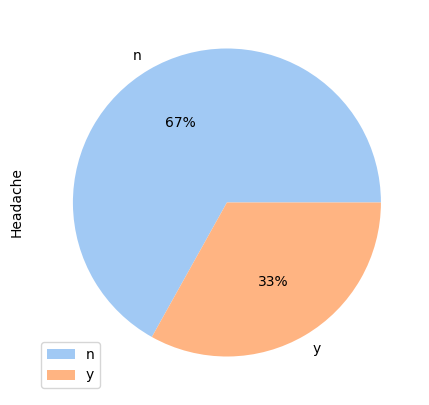

In [15]:
colors = sns.color_palette('pastel')
classes = pd.value_counts(df["Headache"])
classes.plot(kind='pie', figsize=(5,5), autopct='%0.f%%', legend=True, colors = colors)
plt.show() 

Then loading the period dataset in the same format and adding the period values to the migraine dataframe.

In [16]:
period_df = pd.read_csv('period_diary.csv', encoding='latin-1', sep=';')
period_df['date'] = pd.to_datetime(period_df['date'], errors = 'coerce', format='%d.%m.%Y')
period_df.drop_duplicates(subset='date', inplace=True)
df['Period'] = period_df['period']
df.head()

,Date,Headache,Intensity,Period
0,2020-09-26,y,7.0,y
1,2020-09-27,n,0.0,y
2,2020-09-28,n,0.0,y
3,2020-09-29,n,0.0,y
4,2020-09-30,n,0.0,y


In [17]:
first_date = df.Date.iloc[0].date()
last_date = df.Date.iloc[-1].date()
delta = last_date - first_date

print('The journal starts on', first_date)
print('The journal ends on', last_date)
print('Total days:', delta.days)
print('Days without headache:', df.Headache.value_counts()['n'])
print('Days with headache:', df.Headache.value_counts()['y'])
print('Average headache intensity:', df[df.Intensity != 0].Intensity.mean())


The journal starts on 2020-09-26
The journal ends on 2022-04-24
Total days: 575
Days without headache: 384
Days with headache: 190
Average headache intensity: 4.110526315789474


## 2. Preparing data

Breaking down the data into 30-day periods for the purposes of visualization and convenience of use.

In [18]:
months = delta.days // 30
split_dfs = np.array_split(df, months)
print('Number of 30-day splits:', len(split_dfs))

Number of 30-day splits: 19


In [19]:
'''In order to achieve a smooth plotline, this function
breaks down days into hours and interpolates 
the migraine Intensity values according to hours,
returning a new dataframe that is indexed by hour,
as well as the new indices list
'''

def smooth_migraine(df):
    
    startDate = list(df['Date'])[0]
    endDate = list(df['Date'])[-1]
    index = pd.date_range(startDate, endDate)
    data = list(df['Intensity'])
    cols =['value']

    df = pd.DataFrame(data, index=index, columns = cols)
    index_hourly = pd.date_range(startDate, endDate, freq='1H')
    df_smooth = df.reindex(index=index_hourly).interpolate(method='pchip')
    return df_smooth, index_hourly

In [20]:
# Taking a look at the first split of the new dataframe indexed by hour

df_smooth, index_hourly = smooth_migraine(split_dfs[0])
df_smooth

,value
2020-09-26 00:00:00,7.000000
2020-09-26 01:00:00,6.562753
2020-09-26 02:00:00,6.127025
2020-09-26 03:00:00,5.694336
2020-09-26 04:00:00,5.266204
...,...
2020-10-25 20:00:00,0.000000
2020-10-25 21:00:00,0.000000
2020-10-25 22:00:00,0.000000
2020-10-25 23:00:00,0.000000


In [26]:
'''Function that extracts dates of period and ovulation
from a dataframe'''

def period_lists(df):
    y_dates=[]
    o_dates=[]
    for index, row in df.iterrows():
        if row['Period']=='y':
            date=row['Date'].date()
            y_dates.append(date)
        if row['Period']=='o':
            date=row['Date'].date()
            o_dates.append(date)
    return y_dates, o_dates

In [27]:
y_dates, o_dates = period_lists(split_dfs[0])
print(y_dates, o_dates)

[datetime.date(2020, 9, 26), datetime.date(2020, 9, 27), datetime.date(2020, 9, 28), datetime.date(2020, 9, 29), datetime.date(2020, 9, 30), datetime.date(2020, 10, 26)] [datetime.date(2020, 10, 11)]


In [23]:
'''This function creates a list of values for the Period column
of the new dataframe indexed by hour by checking if the dates 
are in the previously created lists of period and ovulation dates,
where y = period
n = no period
o = ovulation
and adds this list to the dataframe indexed by hours,
returning the dataframe'''

def smooth_period(df_smooth, y_dates, o_dates):
    period_list=[]
    for i in index_hourly:
        if i.date() in y_dates:
            period_list.append('y')
        elif i.date() in o_dates:
            period_list.append('o')
        else:
            period_list.append('n')
        
    df_smooth['period']=period_list
    return df_smooth

<AxesSubplot: ylabel='value'>

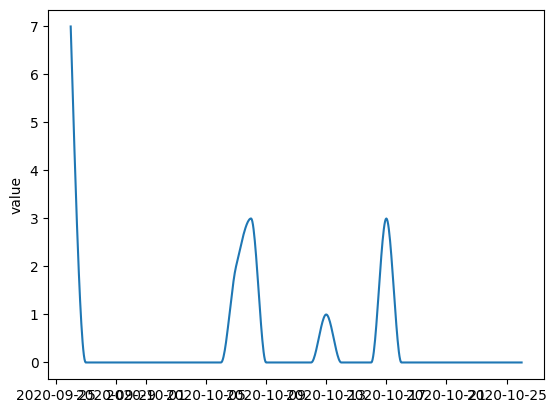

In [28]:
df_smooth_period = smooth_period(df_smooth, y_dates, o_dates)
sns.lineplot(data=df_smooth_period, x=df_smooth_period.index, y = df_smooth_period['value'])

In [29]:
def label_span(df_smooth_period):
    datespans=[]
    label0 = 'label'
    datespan = []
    labels=[]

    for index, row in df_smooth_period.iterrows():
        label = row['period']    
        if label != label0:
            datespans.append(datespan)
            labels.append(label)
            datespan = []
            datespan.append(index)
            label0 = label
        elif label == label0:
            datespan.append(index)
    datespans.append(datespan)
    labels.append(label)

    del datespans[:1]
    del labels[-1:]
    
    return labels, datespans


In [30]:
labels, datespans = label_span(df_smooth_period)
print(labels, len(datespans))

['y', 'n', 'o', 'n', 'y'] 5


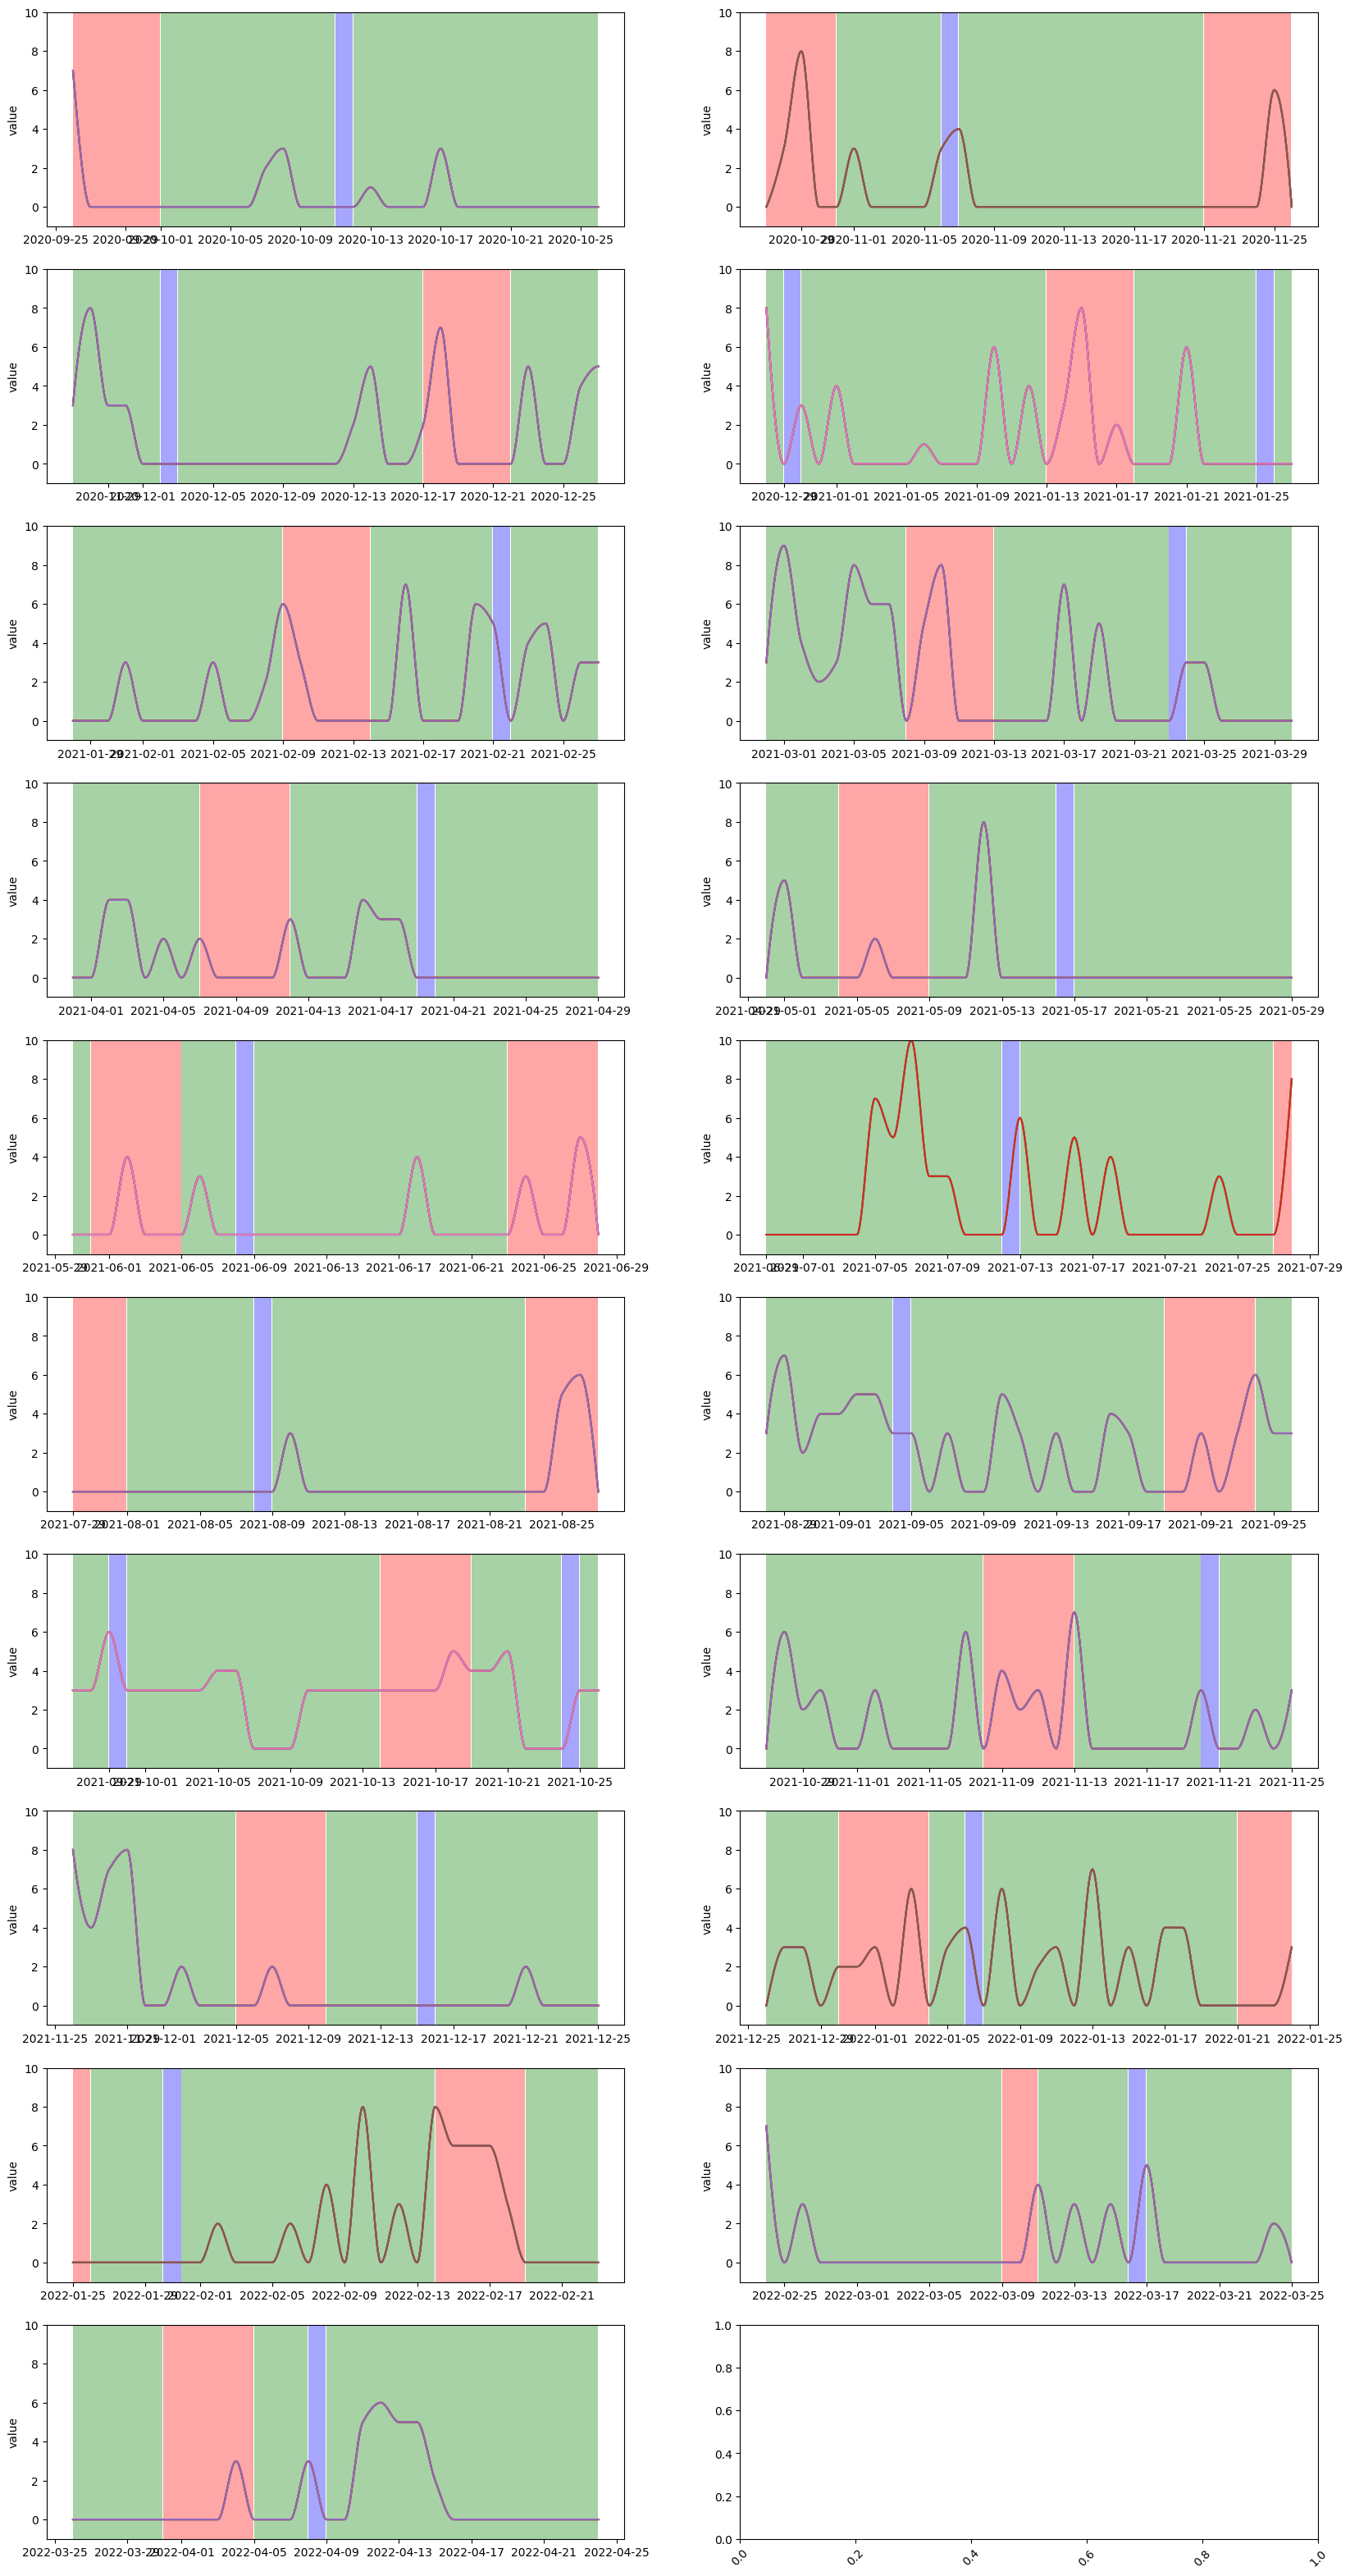

In [31]:
fig, axes = plt.subplots(nrows = 10, ncols =2)
fig.set_size_inches(20,40)
row_coord = 0
col_coord = 0
ind = 0

for df in split_dfs:
    df_smooth, index_hourly = smooth_migraine(df)
    y_dates, o_dates = period_lists(df)
    df_smooth_period = smooth_period(df_smooth, y_dates, o_dates)
    labels, datespans = label_span(df_smooth_period)
    ax = axes[row_coord, col_coord]

    y = df_smooth_period['value']
    ax.set_ylim([-1, 10])
    plt.xticks(rotation=45)
    for label, span in zip(labels, datespans):
        if label=='y':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='red')
        if label=='n':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='green')
        if label=='o':
            ax.axvspan(span[0], span[-1], alpha=0.35, facecolor='blue')
        sns.lineplot(data=df_smooth_period, x=df_smooth_period.index, y=y, ax=ax)

    
    
    if ind % 2 == 0:
        col_coord = 1
    else:
        row_coord += 1
        col_coord=0
    ind += 1
    
